---

# HandsOn_14-1

<br>

* created by thk. 20.10.21.

---

---

## Filter, Strides, Padding, Pooling

<br> 

* 참고 자료 - http://taewan.kim/post/cnn/

<br>

* **CNN MODEL EXAMPLE**

<br>

![nn](CNN.png)

<br>

* **Filter 2 x 2 & Strides 1**

<br>

![nn](filter.png)

<br>

* **Padding**

<br>

![nn](padding.png)

<br>

* **Pooling 2 x 2**

<br>

![nn](pooling.png)

<br>


---

## CNN output size 계산법

<br>

* **Parameters**

    * input_size - N
    * filter (convolution) kernel_size - k
    * pooling kernel_size - PL
    * strides size - S
    * padding size = PD
    * output_size - O

<br>

* **Convolutional layer의 출력 크기**

<br>

O = ((N - k + 2PD) / S) + 1

<br>

* **Pooling layer의 출력 크기**

O = N/PL

<br>

---

## CNN 모델 구현하기

<br>

In [45]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 텐서플로 ≥2.0 필수
import tensorflow as tf
from tensorflow.keras import layers, models
assert tf.__version__ >= "2.0"

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

import pandas as pd
import seaborn as sns

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

def plot_loss(history):
    plt.plot(pd.DataFrame(history.history))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.legend(('loss', 'v_loss'))
    plt.show()

In [24]:
# load
(img, y_train), (img_test, y_test) = tf.keras.datasets.mnist.load_data()
print('* Load')
print('Train set: ', img.shape, img[0][10])
print('Test set: ', img_test.shape, img_test[0][10])

* Load
Train set:  (60000, 28, 28) [  0   0   0   0   0   0   0   0   0  14   1 154 253  90   0   0   0   0
   0   0   0   0   0   0   0   0   0   0]
Test set:  (10000, 28, 28) [  0   0   0   0   0   0   0   0   0   0   0  17  66  14  67  67  67  59
  21 236 254 106   0   0   0   0   0   0]


In [32]:
def preProcessing(img, img_test):

    # reshape
    # 차원 3 추가
    print('* Reshape')
    x_train = np.reshape(img, (img.shape[0], img.shape[1], img.shape[2], 1))
    x_test = np.reshape(img_test, (img_test.shape[0], img_test.shape[1], img_test.shape[2], 1))
    print(x_train.shape)
    print(x_test.shape)
    
    # Normalize
    print('* Normailze')
    x_train = x_train / 255
    x_test = x_test / 255
    print(x_train.shape)
    print(x_test.shape)
    
    return x_train, x_test

In [33]:
img.shape[0]
img.shape[1]*img.shape[2]*1

784

In [34]:
x_train, x_test = preProcessing(img, img_test)

* Reshape
(60000, 28, 28, 1)
(10000, 28, 28, 1)
* Normailze
(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [39]:
model = tf.keras.models.Sequential([
    layers.Conv2D(64, 7, activation="relu", padding ="same",
                       input_shape=[28,28,1]),
    layers.MaxPooling2D(2), # , strides=1
    layers.Conv2D(128, 3, activation = "relu", padding="same"),
    layers.Conv2D(128, 3, activation = "relu", padding="same"),
    layers.MaxPooling2D(2),
    layers.Conv2D(256, 3, activation = "relu", padding="same"),
    layers.Conv2D(256, 3, activation = "relu", padding="same"),
    layers.MaxPooling2D(2),
    layers.Flatten(),
    layers.Dense(128, activation = "relu"),
    layers.Dropout(0.5),
    layers.Dense(64, activation = "relu"),
    layers.Dropout(0.5),
    layers.Dense(10, activation = "softmax")
])

In [40]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 28, 28, 64)        3200      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 14, 14, 128)       73856     
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 14, 14, 128)       147584    
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 7, 7, 256)         295168    
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 7, 7, 256)        

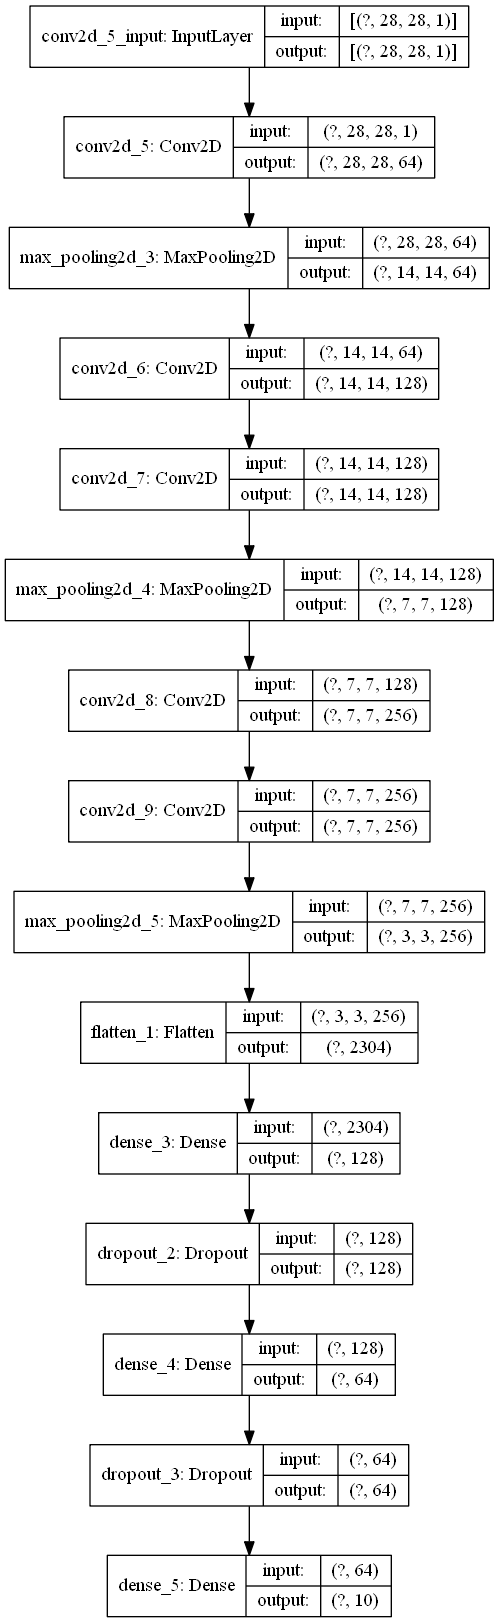

In [17]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [41]:
# 모델 컴파일
model.compile(loss="sparse_categorical_crossentropy", # label이 정수
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Loss
# categorical crossentropy: 분류해야할 클래스가 3개 이상인 멀티클래스 분류에 사용
# categorical_crossentropy - label이 [0,0,1,0,0]과 같이 one-hot 형태로 제공될 때 사용
# sparse categorical crossentropy - label이 0, 1, 2, 3, 4와 같이 정수로 제공될 때 사용

# Optimizer (https://keras.io/ko/optimizers/)
# Adam - keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

# 콜백 선언
model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint('model_cnn_1.h5', 
                                                         save_best_only=True)

# 모델 훈련
model.fit(x_train, y_train, 
          validation_split=0.2,
          epochs=10,
          callbacks=[model_checkpoint_cb])

Epoch 1/10
1500/1500 [==============================] - 429s 286ms/step - loss: 0.4760 - accuracy: 0.8466 - val_loss: 0.1080 - val_accuracy: 0.9731
Epoch 2/10
1500/1500 [==============================] - 438s 292ms/step - loss: 0.1352 - accuracy: 0.9672 - val_loss: 0.0625 - val_accuracy: 0.9845
Epoch 3/10
1500/1500 [==============================] - 424s 282ms/step - loss: 0.0937 - accuracy: 0.9777 - val_loss: 0.0990 - val_accuracy: 0.9759
Epoch 4/10
1500/1500 [==============================] - 428s 285ms/step - loss: 0.0838 - accuracy: 0.9804 - val_loss: 0.0409 - val_accuracy: 0.9907
Epoch 5/10
1500/1500 [==============================] - 432s 288ms/step - loss: 0.0700 - accuracy: 0.9835 - val_loss: 0.0559 - val_accuracy: 0.9901
Epoch 6/10
1500/1500 [==============================] - 429s 286ms/step - loss: 0.0533 - accuracy: 0.9875 - val_loss: 0.0433 - val_accuracy: 0.9912
Epoch 7/10
1500/1500 [==============================] - 430s 287ms/step - loss: 0.0504 - accuracy: 0.9883 - val_

In [42]:
# load model
model_cnn = tf.keras.models.load_model('model_cnn_1.h5')

# evaluate model
cnn_test = model_cnn.evaluate(x_test, y_test)

313/313 [==============================] - 21s 66ms/step - loss: 0.0335 - accuracy: 0.9916


In [43]:
# 훈련 후 모델 예측
y_pred = model_cnn.predict(x_test)
y_pred_class = np.argmax(y_pred, axis=1)
y_pred_class = y_pred_class.tolist()

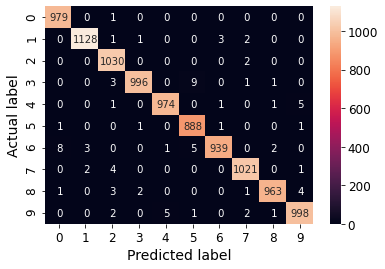

In [48]:
p = sns.heatmap(confusion_matrix(y_test,y_pred_class),annot=True,fmt='2.0f')
p.set_ylabel('Actual label');
p.set_xlabel('Predicted label');

In [47]:
print(classification_report(y_test, y_pred_class))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       1.00      0.99      0.99      1135
           2       0.99      1.00      0.99      1032
           3       1.00      0.99      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.98      1.00      0.99       892
           6       0.99      0.98      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.99      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



---

## ResNET 

<br>

<br>

* 참고
    * https://bskyvision.com/644
    * https://blog.naver.com/laonple/220761052425

<br>

* He, K., Zhang, X., Ren, S., & Sun, J. (2016). Deep residual learning for image recognition. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 770-778).

<br>

* Deep Residual Learning Network

<br>

* 마이크로소프트에서 개발한 이미지 분류용 CNN


* 깊은 망의 문제점을 해결하기 위해 개발. network가 깊을수록 수행이 좋아지지만, vanishing/exploding gradient나 연산량의 증가로 인한 오류 발생으로 수행이 감소할 수 있음.


* 깊이 증가에 따른 학습 효과를 증가시키기 위해 Residual을 활용한 Learning 방법을 제안


* 기존 신경망은 입력 x에 대하여 학습을 통해 최적의 output (H(x)) 을 산출하기 위해 weight를 계산 (F(x))


* ResNet에선 입력 -> 출력으로의 shortcut 연결을 추가하여 최적의 output (H(x) + x) 을 얻도록 F(x)가 H(x) -x를 얻기위한 학습을 하도록 유도함.

<br>

![nn](resnet.png)

<br>

* 이를 통해 깊은 망에서도 쉽게 최적화를 할 수 있으며, 정확도를 개선할 수 있다고 함..

<br>